In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import tqdm
%matplotlib inline

# Parameters
epochs = 3
dense_rlambda = 1e-4
dense_lr = 1e-4
dropout_p = 0.5
norm_epsilon = 1e-4

# Classes

# One-hot encoder for MNIST
class OneHotEncoder:
    
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    
    def transform(self, y):
        return self.transform_mapping[int(y)]


# Fully connected layer
class Dense:
    
    def __init__(self, in_size, out_size):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = dense_rlambda
        
    def forward(self, x):
        # Remember for a backward pass
        self.x = x
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz):
        # Calculate gradients by parameters (remember them for debugging)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # Calculate the input derivative
        self.dx = np.matmul(dz, self.W) 
        # Calculate the gradients from the regularizer
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # Update weights
        self.W = self.W - dense_lr * self.dW
        self.b = self.b - dense_lr * self.db
        # Return dx to continue the algorithm
        return self.dx
    

# Rectified linear unit
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz):
        dz[self.x < 0] = 0
        return dz
    
    
# Normalized exponential function
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)
    
    
# Measures the performance of a classification model
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -1. * np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz):
        return -1. * dz * self.y_true / self.y_hat
    

# Regularization technique for reducing overfitting
class Dropout:
    def __init__(self):
        self.p = dropout_p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz):
        return dz * self.mask
    
    
# The definition of the network
class MnistNet:
    
    def __init__(self):
        self.d1 = Dense(784, 100)
        self.m1 = ReLU()
        #self.d2 = Dense(2500, 1000)
        #self.m2 = ReLU()
        #self.d3 = Dense(1000, 500)
        #self.m3 = ReLU()
        #self.d4 = Dense(500, 200)
        #self.m4 = ReLU()
        self.d5 = Dense(100, 50)
        self.m5 = ReLU()
        self.d6 = Dense(50, 10)
        #self.m6 = ReLU()
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        #net = self.d2.forward(net)
        #net = self.m2.forward(net)
        #net = self.d3.forward(net)
        #net = self.m3.forward(net)
        #net = self.d4.forward(net)
        #net = self.m4.forward(net)
        net = self.d5.forward(net)
        net = self.m5.forward(net)
        net = self.d6.forward(net)
        #net = self.m6.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz):
        dz = self.s.backward(dz)
        #dz = self.m6.backward(dz)
        dz = self.d6.backward(dz)
        dz = self.m5.backward(dz)
        dz = self.d5.backward(dz)
        #dz = self.m4.backward(dz)
        #dz = self.d4.backward(dz)
        #dz = self.m3.backward(dz)
        #dz = self.d3.backward(dz)
        #dz = self.m2.backward(dz)
        #dz = self.d2.backward(dz)
        dz = self.m1.backward(dz)
        dz = self.d1.backward(dz)
        return dz
    
    
# Functions

def data_normalization(data):
    data = data.astype('float')
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / (std + norm_epsilon)

# Y_test in the non-one-hot format
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

def make_submission(X_test, net, fname="submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))
            

# Main code block

encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
#with open('data_test_no_labels.pickle','rb') as fin:
#    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))

#X_test = test_data['data']

# Подготовка датасета
X_train = data_normalization(X_train)

# Splitting data on the training and the test samples
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, random_state=10)

In [40]:
# Здесь процедура обучения
net = MnistNet()
loss = CrossEntropy()

L_train = []
L_test = []
for iter in tqdm.tqdm_notebook(range(epochs)):
    L_acc = 0.
    sh = list(range(X_train.shape[0]))
    np.random.shuffle(sh)
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = Y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L 
        dz = loss.backward(1.)
        dz = net.backward(dz)
    L_acc /= Y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= Y_test.shape[0]
    L_test.append(L_e_acc)
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))

0 iter loss. Train : 102.54264969970639 . Test : 102.72531057335321
1 iter loss. Train : 102.45563255029735 . Test : 102.72373125087218
2 iter loss. Train : 102.45481788900075 . Test : 102.7232824512011


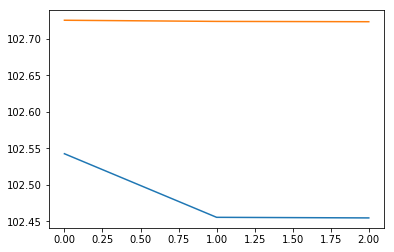

In [41]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label="train")
plt.plot(L_test, label="test")

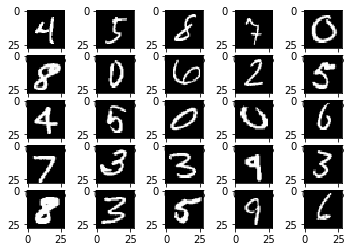

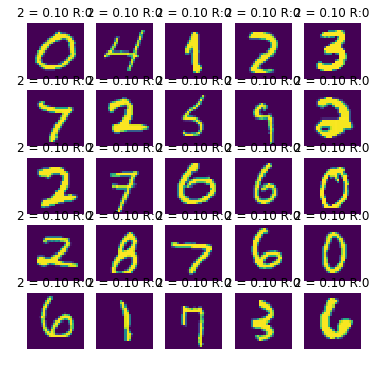

In [42]:
n=5
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')
    
plt.figure(figsize=(6,6))

sh = list(range(X_test.shape[0]))
np.random.shuffle(sh)

n = 5
for i in range(n*n):
    ax = plt.subplot(n, n, i+1)

    j = sh[i]
    R = np.argmax(Y_test[j])
    P = net.forward(X_test[j])
    Rp = np.argmax(P)

    ax.set_title('%s = %.2f R:%s' % (Rp, P[Rp], R))
    ax.set_axis_off()
    plt.imshow(X_test[j].reshape((28, 28)))

In [ ]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_norm, net)